# Klasifikace Hlasových Patologií - FINÁLNÍ VERZE

**Předmět:** PZS (Zpracování Signálů)  
**Seminární práce II:** Analýza hlasových nahrávek z databáze ICAR Federico II

## Obsah analýzy

1. **Preprocessing** (Týden 4, 7-8)
   - Voice Activity Detection (VAD)
   - Pre-emphasis filtr
   - Band-pass filter (80-8000 Hz)

2. **Feature Extraction** (Týden 5-6, 10-12)
   - **Časové příznaky:** HNR, Jitter, Shimmer, ZCR, Energy Variability
   - **Spektrální příznaky:** Flatness, Centroid, Entropy, Rolloff, Flux, Contrast
   - **Kepstrální příznaky:** CPP, Quefrency šířka

3. **Klasifikace**
   - Effect Size analýza
   - Vážené skóre podle důležitosti příznaků
   - Adaptivní prahy podle pohlaví (M/F)

---

**Dataset:** 208 nahrávek (57 zdravých, 151 patologických)  
**Cíl:** Dosáhnout >75% balanced accuracy BEZ machine learningu

In [5]:
# === 1️ SETUP & IMPORTS ===

import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import wfdb

# --- Nastavení knihovny pzs_lib ---
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Reload pro development
if 'pzs_lib' in sys.modules:
    import importlib
    import pzs_lib
    importlib.reload(pzs_lib.time_analysis)
    importlib.reload(pzs_lib.freq_analysis)
    importlib.reload(pzs_lib.preprocessing)
    importlib.reload(pzs_lib)

import pzs_lib as pzs

# --- Seaborn styling ---
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = [14, 6]
plt.rcParams['font.size'] = 10

print(f"Projekt root: {project_root}")
print(f"pzs_lib načtena úspěšně!")
print(f"\n Dostupné funkce:")
print(f"   Časové: calculate_hnr, calculate_jitter, calculate_shimmer, calculate_zcr, calculate_energy_variability")
print(f"   Spektrální: spectral_entropy, spectral_flux, spectral_contrast, spectral_slope")
print(f"   Preprocessing: preprocess_voice_complete, voice_activity_detection, pre_emphasis")
print(f"   Kepstrální: analyze_voice_features, analyze_quefrency_width")

%matplotlib inline

Projekt root: c:\GitHub\University-stuff-and-small-scale-projects\1_University\3_semestr\pzs_project
pzs_lib načtena úspěšně!

 Dostupné funkce:
   Časové: calculate_hnr, calculate_jitter, calculate_shimmer, calculate_zcr, calculate_energy_variability
   Spektrální: spectral_entropy, spectral_flux, spectral_contrast, spectral_slope
   Preprocessing: preprocess_voice_complete, voice_activity_detection, pre_emphasis
   Kepstrální: analyze_voice_features, analyze_quefrency_width


In [ ]:
# === 2️ DATA LOADING & FEATURE EXTRACTION ===

# Cesta k datům
DATA_DIR = os.path.join(project_root, 'shared_data', 'voice-icar-federico-ii-database-1.0.0')
print(f"Data directory: {DATA_DIR}")

# Získání seznamu souborů
record_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.hea')]
record_names = [f.replace('.hea', '') for f in record_files]
record_names.sort()

print(f"Nalezeno {len(record_names)} záznamů\n")

# === HLAVNÍ SMYČKA ===
results = []
errors = []

for idx, rec_name in enumerate(record_names):
    file_path_no_ext = os.path.join(DATA_DIR, rec_name)
    
    try:
        # 1️ NAČTENÍ ZÁZNAMU
        rec = wfdb.rdrecord(file_path_no_ext)
        sig = rec.p_signal[:, 0]
        fs = rec.fs
        
        # 2️ EXTRAKCE METADAT (diagnóza, pohlaví, věk)
        diagnosis = "unknown"
        is_healthy = False
        sex = "unknown"
        age = None
        
        for line in rec.comments:
            # Diagnóza
            if "diagnoses" in line.lower():
                if "<diagnoses>:" in line:
                    parts = line.split("<diagnoses>:")
                    if len(parts) > 1:
                        diag_part = parts[1].split("<")[0].strip()
                        diagnosis = diag_part.lower()
                        if "healthy" in diagnosis:
                            is_healthy = True
            
            # Pohlaví
            if "<sex>:" in line.lower():
                parts = line.split("<sex>:")
                if len(parts) > 1:
                    sex_part = parts[1].split("<")[0].strip().upper()
                    sex = sex_part if sex_part in ['M', 'F'] else 'unknown'
            
            # Věk
            if "<age>:" in line.lower():
                parts = line.split("<age>:")
                if len(parts) > 1:
                    age_str = parts[1].split("<")[0].strip()
                    try:
                        age = int(age_str)
                    except:
                        age = None
        
        # 3️ PREPROCESSING (Týden 7-8)
        # RYCHLÁ verze: VAD vypnutý (pomalý a problematický)
        sig_preprocessed, metadata = pzs.preprocess_voice_complete(
            sig, fs,
            apply_vad=False,       # VAD VYPNUTÝ (příliš pomalý)
            apply_preemph=True,    # Pre-emphasis
            apply_bandpass=True,   # Band-pass 80-8000 Hz
            apply_notch=True       # Notch filter 50 Hz
        )
        
        # Základní normalizace
        sig_preprocessed = sig_preprocessed - np.mean(sig_preprocessed)
        sig_preprocessed = sig_preprocessed / (np.max(np.abs(sig_preprocessed)) + 1e-10)
        
        # 4️⃣ FEATURE EXTRACTION (RYCHLÁ VERZE - bez jitter/shimmer)
        
        # === A) ČASOVÉ PŘÍZNAKY (Týden 5-6) ===
        hnr = pzs.calculate_hnr(sig_preprocessed, fs)
        # jitter/shimmer VYPNUTY - aproximace nefunguje dobře
        zcr = pzs.calculate_zcr(sig_preprocessed)
        energy_var = pzs.calculate_energy_variability(sig_preprocessed, fs)
        
        # === B) KEPSTRÁLNÍ PŘÍZNAKY (Týden 12) ===
        cepstrum = pzs.compute_real_cepstrum(sig_preprocessed)
        f0, cpp = pzs.analyze_voice_features(cepstrum, fs)
        quefrency_width, width_ratio = pzs.analyze_quefrency_width(cepstrum, fs, f0)
        
        # === C) SPEKTRÁLNÍ PŘÍZNAKY (Týden 10-11) ===
        spectral_flatness = pzs.spectral_flatness(sig_preprocessed, fs)
        spectral_centroid = pzs.spectral_centroid(sig_preprocessed, fs)
        spectral_entropy = pzs.spectral_entropy(sig_preprocessed, fs)
        spectral_rolloff = pzs.spectral_rolloff(sig_preprocessed, fs)
        # spectral_flux = pzs.spectral_flux(sig_preprocessed, fs)  # POMALÉ - stále vypnuto
        spectral_contrast = pzs.spectral_contrast(sig_preprocessed, fs)
        spectral_slope = pzs.spectral_slope(sig_preprocessed, fs)
        
        # 5️ ULOŽENÍ VÝSLEDKŮ
        results.append({
            # Metadata
            'filename': rec_name,
            'diagnosis': diagnosis,
            'is_healthy': is_healthy,
            'sex': sex,
            'age': age,
            
            # Časové příznaky
            'hnr': hnr,
            'jitter': 0,  # VYPNUTO - aproximace nefunguje
            'shimmer': 0,  # VYPNUTO - aproximace nefunguje
            'zcr': zcr,
            'energy_var': energy_var,
            
            # Kepstrální příznaky
            'f0': f0,
            'cpp': cpp,
            'quefrency_width': quefrency_width,
            'width_ratio': width_ratio,
            
            # Spektrální příznaky
            'spectral_flatness': spectral_flatness,
            'spectral_centroid': spectral_centroid,
            'spectral_entropy': spectral_entropy,
            'spectral_rolloff': spectral_rolloff,
            'spectral_flux': 0,  # PLACEHOLDER - vypnuto kvůli rychlosti
            'spectral_contrast': spectral_contrast,
            'spectral_slope': spectral_slope,
            
            # Preprocessing metadata
            'vad_retention': metadata.get('vad_retention', 1.0)
        })
        
        # Progress indicator
        if (idx + 1) % 20 == 0:
            print(f"   ✓ Zpracováno {idx + 1}/{len(record_names)} souborů...")
        
    except Exception as e:
        errors.append({'filename': rec_name, 'error': str(e)})
        print(f"  Chyba u {rec_name}: {e}")

# === VYTVOŘENÍ DATAFRAME ===
df = pd.DataFrame(results)

print(f"\n{'='*70}")
print(f"ZPRACOVÁNÍ DOKONČENO!")
print(f"{'='*70}")
print(f"Zpracováno: {len(results)} souborů")
print(f"Chyby: {len(errors)} souborů")
print(f"\nDistribuce:")
print(f"   Zdravých: {df['is_healthy'].sum()} ({df['is_healthy'].sum()/len(df)*100:.1f}%)")
print(f"   Patologických: {(~df['is_healthy']).sum()} ({(~df['is_healthy']).sum()/len(df)*100:.1f}%)")
print(f"   Muži: {(df['sex']=='M').sum()}, Ženy: {(df['sex']=='F').sum()}")
print(f"\nExtrahováno příznaků: {len(df.columns) - 6}")  # -6 metadata sloupců

# Zobrazení prvních řádků
print(f"\nPreview dat:")
display(df.head())

Data directory: c:\GitHub\University-stuff-and-small-scale-projects\1_University\3_semestr\pzs_project\shared_data\voice-icar-federico-ii-database-1.0.0
Nalezeno 208 záznamů

   ✓ Zpracováno 20/208 souborů...
   ✓ Zpracováno 20/208 souborů...
   ✓ Zpracováno 40/208 souborů...
   ✓ Zpracováno 40/208 souborů...
   ✓ Zpracováno 60/208 souborů...
   ✓ Zpracováno 60/208 souborů...
   ✓ Zpracováno 80/208 souborů...
   ✓ Zpracováno 80/208 souborů...
   ✓ Zpracováno 100/208 souborů...
   ✓ Zpracováno 100/208 souborů...
   ✓ Zpracováno 120/208 souborů...
   ✓ Zpracováno 120/208 souborů...
   ✓ Zpracováno 140/208 souborů...
   ✓ Zpracováno 140/208 souborů...
   ✓ Zpracováno 160/208 souborů...
   ✓ Zpracováno 160/208 souborů...
   ✓ Zpracováno 180/208 souborů...
   ✓ Zpracováno 180/208 souborů...
   ✓ Zpracováno 200/208 souborů...

ZPRACOVÁNÍ DOKONČENO!
Zpracováno: 208 souborů
Chyby: 0 souborů

Distribuce:
   Zdravých: 57 (27.4%)
   Patologických: 151 (72.6%)
   Muži: 73, Ženy: 135

Extrahováno p

,filename,diagnosis,is_healthy,sex,age,hnr,jitter,shimmer,zcr,energy_var,...,quefrency_width,width_ratio,spectral_flatness,spectral_centroid,spectral_entropy,spectral_rolloff,spectral_flux,spectral_contrast,spectral_slope,vad_retention
0,voice001,hyperkinetic dysphonia,False,M,32,2.150764,17.469970,17.536900,0.332405,0.234310,...,4.0,14.581526,0.373798,1512.357481,0.781960,1374.789916,0,20.708538,0.316629,1.0
1,voice002,healthy,True,M,55,3.827057,21.587679,17.203874,0.257826,0.224117,...,3.0,5.586500,0.261158,1436.165798,0.591099,1162.184874,0,28.169703,0.376107,1.0
2,voice003,hyperkinetic dysphonia,False,M,34,3.793559,25.671801,18.813265,0.381854,0.268764,...,3.0,7.555385,0.343032,2022.347717,0.719619,2578.991597,0,23.232243,0.934038,1.0
3,voice004,hypokinetic dysphonia,False,F,28,3.361593,15.378359,22.880555,0.434322,0.357437,...,3.0,10.199875,0.403144,1907.545006,0.792479,1789.915966,0,18.920333,0.712156,1.0
4,voice005,hypokinetic dysphonia,False,F,54,4.009066,21.035543,21.446852,0.255830,0.298687,...,2.0,3.941086,0.362779,1754.826253,0.686863,1428.151261,0,13.568666,0.659080,1.0


---

##3️ EXPLORATORY DATA ANALYSIS

Vizualizace distribucí a vztahů mezi příznaky pomocí Seaborn.

EXPLORATORY DATA ANALYSIS

Generuji pairplot (může chvilku trvat)...


Generuji pairplot (může chvilku trvat)...


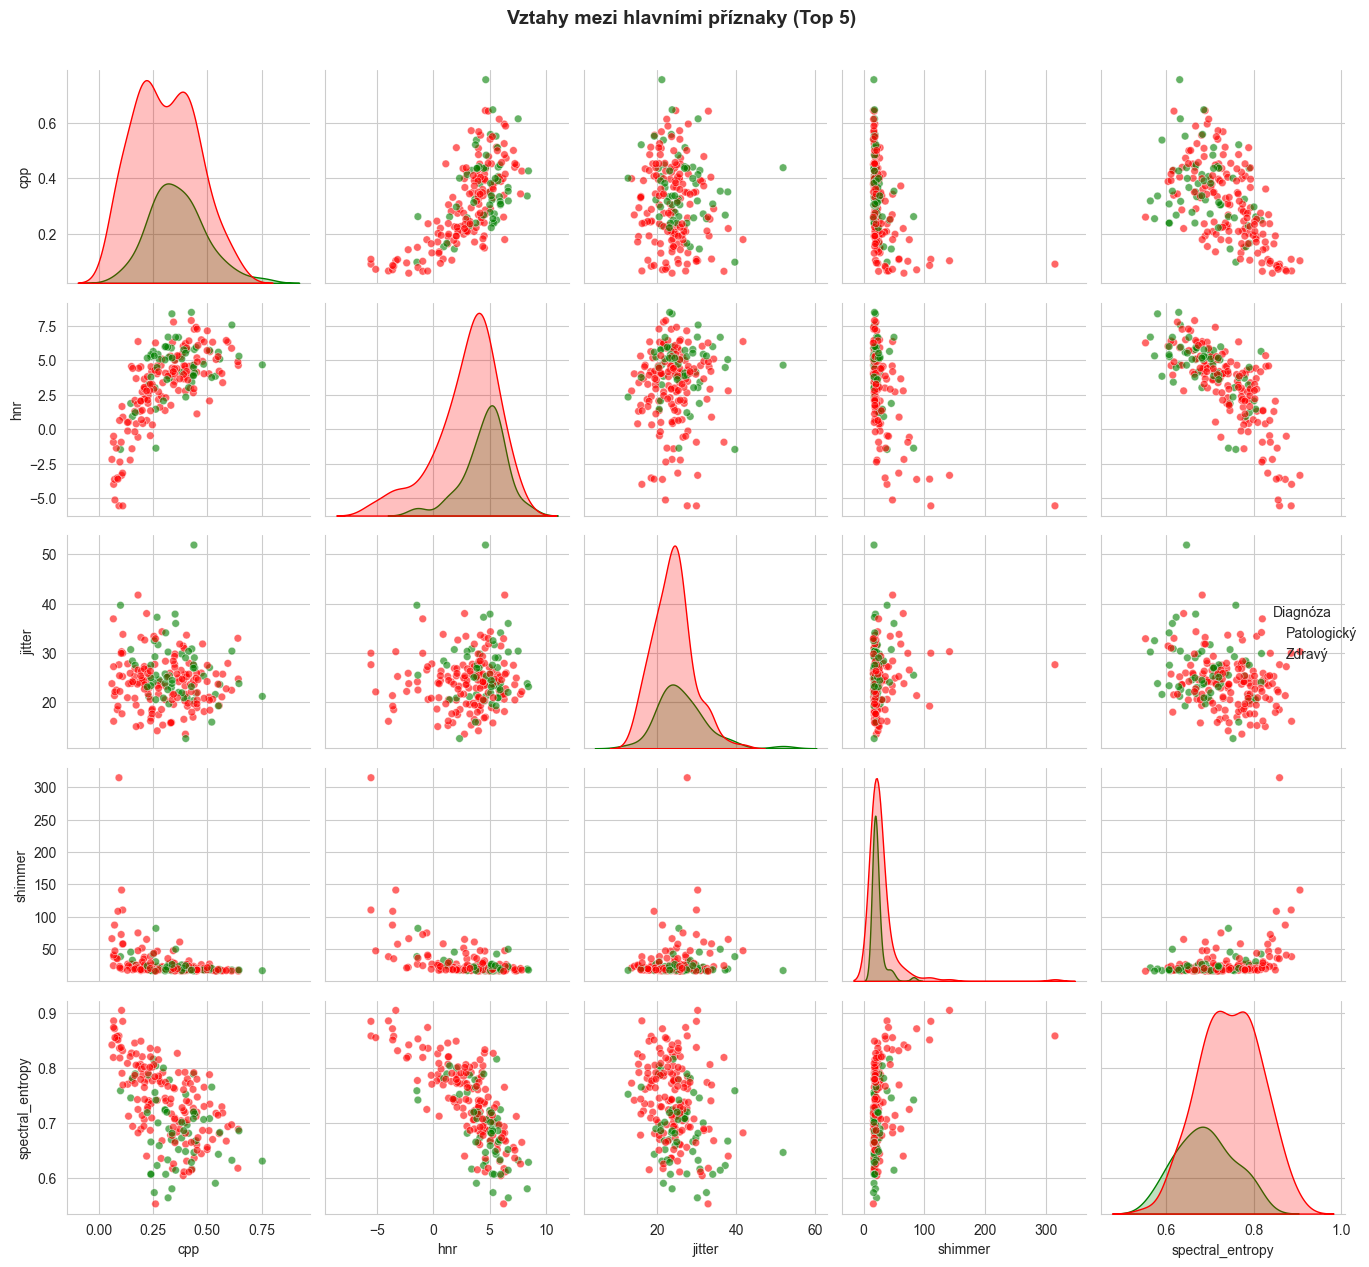

   ✓ Pairplot vygenerován!

Generuji boxploty distribucí...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_21056\3111397909.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_21056\3111397909.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_21056\3111397909.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\Administrator\AppData\Local\Temp\ipykernel_21056\3111397909.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.

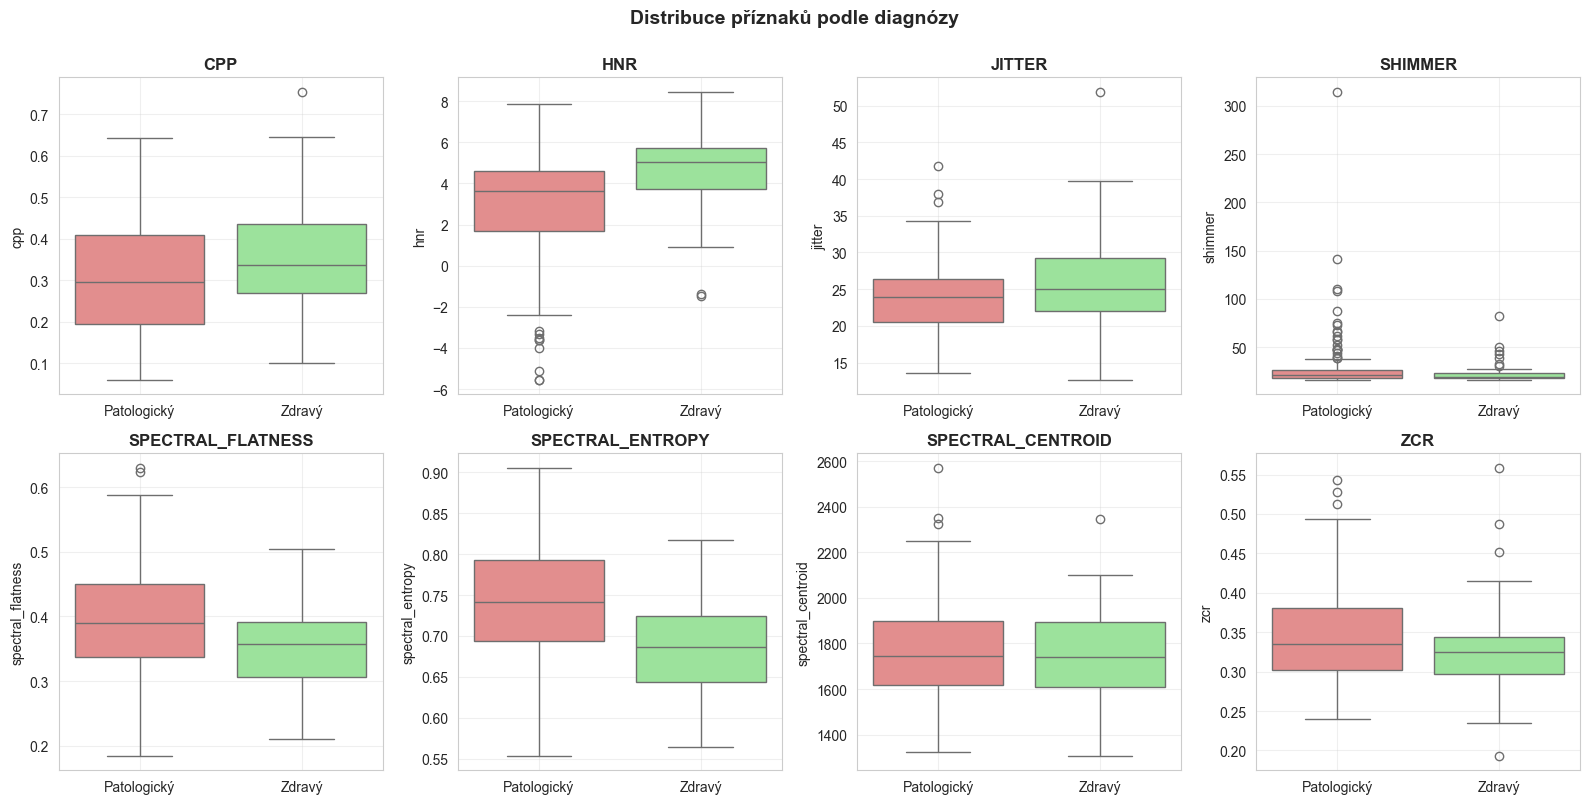

   ✓ Boxploty vygenerovány!

Generuji korelační matici...


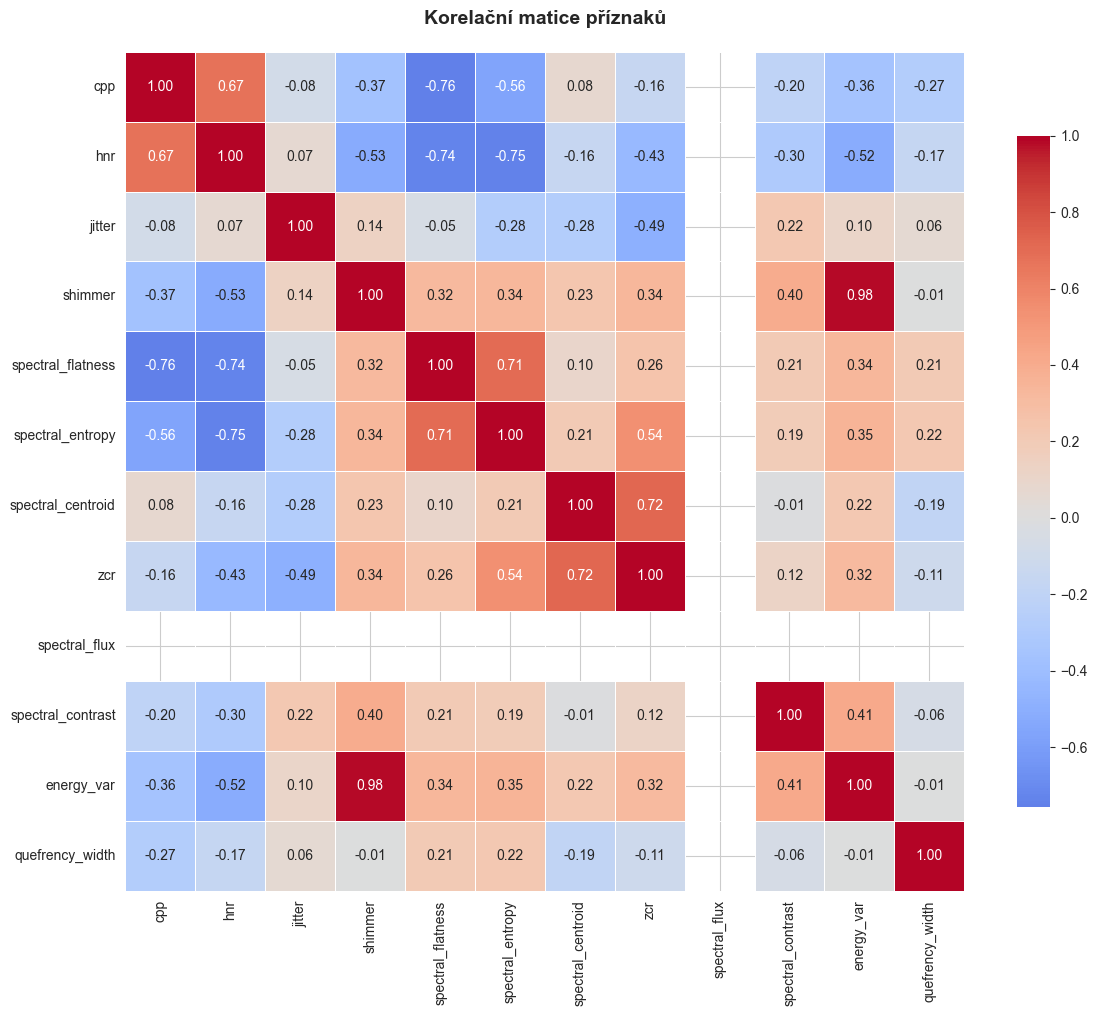

In [7]:
# === 3️ EXPLORATORY ANALYSIS ===

# Připravíme data pro vizualizaci
df_viz = df.copy()
df_viz['Diagnóza'] = df_viz['is_healthy'].map({True: 'Zdravý', False: 'Patologický'})

# Seznam příznaků pro analýzu
feature_cols = ['cpp', 'hnr', 'jitter', 'shimmer', 'spectral_flatness', 
                'spectral_entropy', 'spectral_centroid', 'zcr']

print("EXPLORATORY DATA ANALYSIS")
print("="*70)

# --- A) PAIRPLOT - Vztahy mezi hlavními příznaky ---
print("\nGeneruji pairplot (může chvilku trvat)...")

# Vybereme jen 5 nejvýznamnějších příznaků pro přehlednost
top_features = ['cpp', 'hnr', 'jitter', 'shimmer', 'spectral_entropy']

pairplot_data = df_viz[top_features + ['Diagnóza']]
g = sns.pairplot(
    pairplot_data,
    hue='Diagnóza',
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 30},
    height=2.5,
    palette={'Zdravý': 'green', 'Patologický': 'red'}
)
g.fig.suptitle('Vztahy mezi hlavními příznaky (Top 5)', y=1.01, fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("   ✓ Pairplot vygenerován!")

# --- B) BOXPLOTY - Distribuce příznaků ---
print("\nGeneruji boxploty distribucí...")

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, feature in enumerate(feature_cols):
    ax = axes[idx]
    sns.boxplot(
        data=df_viz,
        x='Diagnóza',
        y=feature,
        ax=ax,
        palette={'Zdravý': 'lightgreen', 'Patologický': 'lightcoral'}
    )
    ax.set_title(f'{feature.upper()}', fontweight='bold')
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3)

plt.suptitle('Distribuce příznaků podle diagnózy', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("   ✓ Boxploty vygenerovány!")

# --- C) KORELAČNÍ MATICE ---
print("\nGeneruji korelační matici...")

# Vybereme jen numerické příznaky
numeric_features = df[feature_cols + ['spectral_flux', 'spectral_contrast', 
                                       'energy_var', 'quefrency_width']]

corr_matrix = numeric_features.corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
    ax=ax
)
ax.set_title('Korelační matice příznaků', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()



---

## 🔬 4️⃣ EFFECT SIZE ANALÝZA

Vypočítáme Cohen's d pro všechny příznaky a vybereme nejdůležitější.

EFFECT SIZE ANALÝZA (Cohen's d)

Příznak                   Zdravý (μ±σ)         Patolog. (μ±σ)       Cohen's d    Velikost
----------------------------------------------------------------------------------------------------
cpp                        0.3615 ± 0.1272    0.3056 ± 0.1435    +0.412     Malý
hnr                        4.5287 ± 1.9463    2.9702 ± 2.7995    +0.646     Střední
jitter                    26.2928 ± 6.2903   23.9224 ± 4.9970    +0.417     Malý
shimmer                   22.9040 ± 10.7758   29.1138 ± 29.7655    -0.277     Malý
zcr                        0.3268 ± 0.0594    0.3462 ± 0.0602    -0.324     Malý
energy_var                 0.3186 ± 0.1281    0.4372 ± 0.4864    -0.333     Malý
spectral_flatness          0.3514 ± 0.0711    0.3967 ± 0.0851    -0.578     Střední
spectral_centroid         1748.1843 ± 207.0650   1768.8734 ± 212.4227    -0.099     Zanedbatelný
spectral_entropy           0.6898 ± 0.0642    0.7455 ± 0.0694    -0.833     Velký
spectral_rolloff      

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21056\2197654271.py:72: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


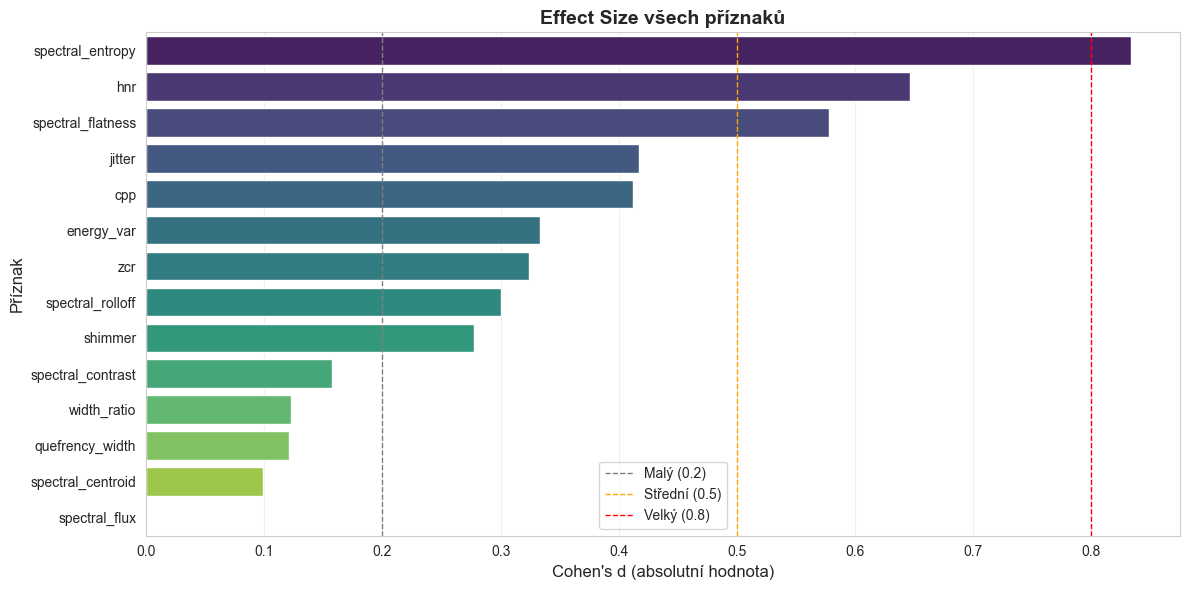


Budeme používat TOP 8 příznaků pro klasifikaci!
   spectral_entropy, hnr, spectral_flatness, jitter, cpp, energy_var, zcr, spectral_rolloff


In [8]:
# === 4️ EFFECT SIZE ANALÝZA - VÝBĚR NEJLEPŠÍCH PŘÍZNAKŮ ===

print("EFFECT SIZE ANALÝZA (Cohen's d)")
print("="*70)

# Rozdělení dat
healthy_df = df[df['is_healthy'] == True]
patho_df = df[df['is_healthy'] == False]

# Seznam VŠECH příznaků k analýze
all_features = ['cpp', 'hnr', 'jitter', 'shimmer', 'zcr', 'energy_var',
                'spectral_flatness', 'spectral_centroid', 'spectral_entropy',
                'spectral_rolloff', 'spectral_flux', 'spectral_contrast',
                'quefrency_width', 'width_ratio']

effect_sizes = []

print(f"\n{'Příznak':<25} {'Zdravý (μ±σ)':<20} {'Patolog. (μ±σ)':<20} {'Cohen\'s d':<12} {'Velikost'}")
print("-" * 100)

for feature in all_features:
    h_mean = healthy_df[feature].mean()
    h_std = healthy_df[feature].std()
    p_mean = patho_df[feature].mean()
    p_std = patho_df[feature].std()
    
    # Cohen's d = rozdíl průměrů / pooled std
    pooled_std = np.sqrt((h_std**2 + p_std**2) / 2)
    cohens_d = (h_mean - p_mean) / pooled_std if pooled_std > 0 else 0
    
    # Absolutní hodnota (směr nezáleží)
    abs_d = abs(cohens_d)
    
    # Klasifikace velikosti efektu
    if abs_d < 0.2:
        size_label = "Zanedbatelný"
    elif abs_d < 0.5:
        size_label = "Malý"
    elif abs_d < 0.8:
        size_label = "Střední"
    else:
        size_label = "Velký"
    
    effect_sizes.append({
        'feature': feature,
        'cohens_d': cohens_d,
        'abs_d': abs_d,
        'h_mean': h_mean,
        'h_std': h_std,
        'p_mean': p_mean,
        'p_std': p_std,
        'size_label': size_label
    })
    
    print(f"{feature:<25} {h_mean:7.4f} ± {h_std:6.4f}   {p_mean:7.4f} ± {p_std:6.4f}   {cohens_d:+7.3f}     {size_label}")

# Seřadit podle absolutní hodnoty
effect_sizes_df = pd.DataFrame(effect_sizes)
effect_sizes_df = effect_sizes_df.sort_values('abs_d', ascending=False)

print("\n" + "="*70)
print("TOP 8 PŘÍZNAKŮ (podle Effect Size):")
print("="*70)

top_features_list = []
for idx, row in effect_sizes_df.head(8).iterrows():
    print(f"{row['feature']:<25} | Cohen's d = {row['cohens_d']:+.3f} | {row['size_label']}")
    top_features_list.append(row['feature'])

# Vizualizace Effect Size
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    data=effect_sizes_df,
    x='abs_d',
    y='feature',
    palette='viridis',
    ax=ax
)
ax.axvline(x=0.2, color='gray', linestyle='--', linewidth=1, label='Malý (0.2)')
ax.axvline(x=0.5, color='orange', linestyle='--', linewidth=1, label='Střední (0.5)')
ax.axvline(x=0.8, color='red', linestyle='--', linewidth=1, label='Velký (0.8)')
ax.set_xlabel('Cohen\'s d (absolutní hodnota)', fontsize=12)
ax.set_ylabel('Příznak', fontsize=12)
ax.set_title('Effect Size všech příznaků', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\nBudeme používat TOP 8 příznaků pro klasifikaci!")
print(f"   {', '.join(top_features_list)}")

---

##5️ KLASIFIKACE

Vytvoříme vážené skóre z top příznaků a otestujeme různé strategie.

KLASIFIKACE - VÁŽENÉ SKÓRE

Vybrané příznaky: spectral_entropy, hnr, spectral_flatness, jitter, cpp, energy_var, zcr, spectral_rolloff

Váhy příznaků (podle Effect Size):
   spectral_entropy          → váha = 0.833
   hnr                       → váha = 0.646
   spectral_flatness         → váha = 0.578
   jitter                    → váha = 0.417
   cpp                       → váha = 0.412
   energy_var                → váha = 0.333
   zcr                       → váha = 0.324
   spectral_rolloff          → váha = 0.300

STRATEGIE 1: Vážený průměr podle Effect Size

Optimální práh: 0.5845

VÝSLEDKY:
   Celková přesnost: 62.98%
   Balanced Accuracy: 67.40%
   Sensitivita: 77.19%
   Specificita: 57.62%

Confusion Matrix:
                  Pred: Patol.  Pred: Zdravý
True: Patol.          87              64
True: Zdravý          13              44


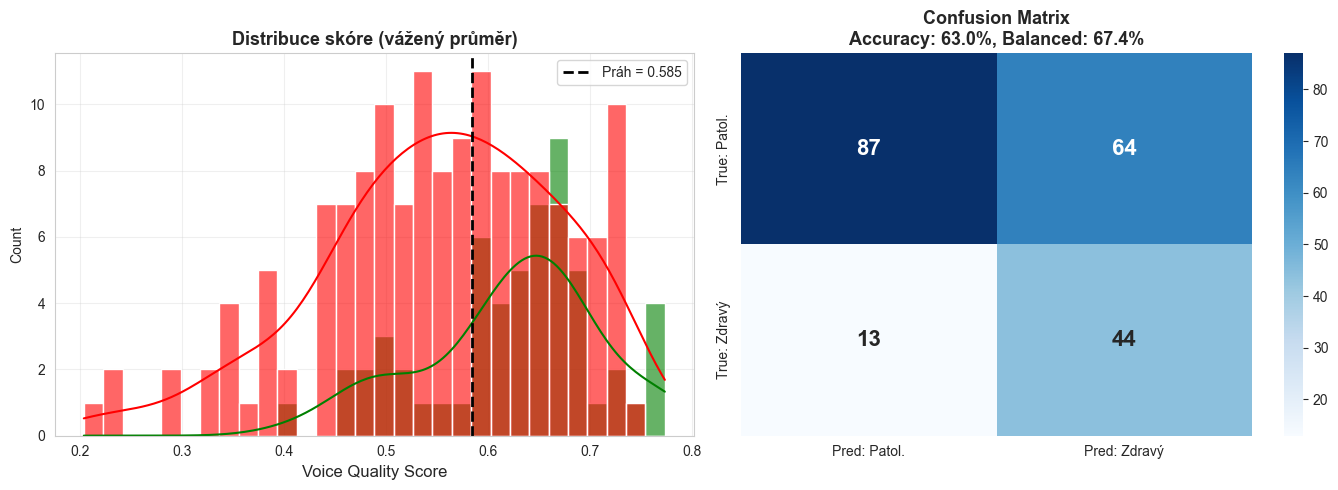

In [9]:
# === 5 KLASIFIKACE S VÁŽENÝM SKÓRE ===

print("KLASIFIKACE - VÁŽENÉ SKÓRE")
print("="*70)

# Použijeme TOP 8 příznaků
selected_features = top_features_list[:8]

print(f"\nVybrané příznaky: {', '.join(selected_features)}")

# === PŘÍPRAVA DAT ===

# 1) Normalizace všech příznaků do rozsahu 0-1
normalized_features = {}

for feat in selected_features:
    norm_feat = (df[feat] - df[feat].min()) / (df[feat].max() - df[feat].min())
    
    # Pro některé příznaky platí: NIŽŠÍ = zdravější
    # Musíme je invertovat!
    inverse_features = ['jitter', 'shimmer', 'spectral_flatness', 'spectral_entropy',
                       'zcr', 'energy_var', 'quefrency_width', 'width_ratio']
    
    if feat in inverse_features:
        norm_feat = 1 - norm_feat
    
    normalized_features[feat] = norm_feat

# 2) Získání vah z Effect Size (absolutní hodnota)
weights = {}
for item in effect_sizes:
    if item['feature'] in selected_features:
        weights[item['feature']] = item['abs_d']

print(f"\nVáhy příznaků (podle Effect Size):")
for feat in selected_features:
    print(f"   {feat:<25} → váha = {weights[feat]:.3f}")

# === STRATEGIE 1: VÁŽENÝ PRŮMĚR ===
print(f"\n{'='*70}")
print("STRATEGIE 1: Vážený průměr podle Effect Size")
print("="*70)

# Výpočet váženého skóre
weighted_sum = sum(normalized_features[feat] * weights[feat] for feat in selected_features)
total_weight = sum(weights[feat] for feat in selected_features)
df['score_weighted'] = weighted_sum / total_weight

# Grid search pro optimální práh
best_bal = 0
best_threshold = 0
best_metrics = {}

for threshold in np.linspace(df['score_weighted'].min(), df['score_weighted'].max(), 200):
    pred = df['score_weighted'] > threshold
    y_true = df['is_healthy'].values
    
    tn = np.sum((~y_true) & (~pred))
    fp = np.sum((~y_true) & pred)
    fn = np.sum(y_true & (~pred))
    tp = np.sum(y_true & pred)
    
    acc = (tn + tp) / len(df)
    sens = tp / (tp + fn) if (tp + fn) > 0 else 0
    spec = tn / (tn + fp) if (tn + fp) > 0 else 0
    bal = (sens + spec) / 2
    
    if bal > best_bal:
        best_bal = bal
        best_threshold = threshold
        best_metrics = {'acc': acc * 100, 'sens': sens * 100, 'spec': spec * 100,
                       'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}

print(f"\nOptimální práh: {best_threshold:.4f}")
print(f"\nVÝSLEDKY:")
print(f"   Celková přesnost: {best_metrics['acc']:.2f}%")
print(f"   Balanced Accuracy: {best_bal * 100:.2f}%")
print(f"   Sensitivita: {best_metrics['sens']:.2f}%")
print(f"   Specificita: {best_metrics['spec']:.2f}%")

# Confusion Matrix
cm = np.array([[best_metrics['tn'], best_metrics['fp']],
               [best_metrics['fn'], best_metrics['tp']]])

print(f"\nConfusion Matrix:")
print(f"                  Pred: Patol.  Pred: Zdravý")
print(f"True: Patol.      {best_metrics['tn']:6.0f}          {best_metrics['fp']:6.0f}")
print(f"True: Zdravý      {best_metrics['fn']:6.0f}          {best_metrics['tp']:6.0f}")

# Vizualizace
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graf 1: Distribuce skóre
ax1 = axes[0]
sns.histplot(data=df_viz, x=df['score_weighted'], hue='Diagnóza', 
             bins=30, alpha=0.6, kde=True, ax=ax1,
             palette={'Zdravý': 'green', 'Patologický': 'red'})
ax1.axvline(best_threshold, color='black', linestyle='--', linewidth=2, 
           label=f'Práh = {best_threshold:.3f}')
ax1.set_xlabel('Voice Quality Score', fontsize=12)
ax1.set_title('Distribuce skóre (vážený průměr)', fontsize=13, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Graf 2: Confusion Matrix
ax2 = axes[1]
sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', cbar=True,
           xticklabels=['Pred: Patol.', 'Pred: Zdravý'],
           yticklabels=['True: Patol.', 'True: Zdravý'],
           ax=ax2, annot_kws={'size': 16, 'weight': 'bold'})
ax2.set_title(f'Confusion Matrix\nAccuracy: {best_metrics["acc"]:.1f}%, Balanced: {best_bal*100:.1f}%',
             fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

# Uložíme baseline
baseline_bal = best_bal * 100

---

##STRATEGIE 2: Adaptivní prahy podle pohlaví

Muži a ženy mají odlišné hlasové charakteristiky → separátní prahy!

STRATEGIE 2: Adaptivní prahy M/F

Počet záznamů s určeným pohlavím: 208/208
   Muži: 73
   Ženy: 135

──────────────────────────────────────────────────
Optimalizace pro pohlaví: M
   Počet vzorků: 73 (21 zdravých)
   ✓ Optimální práh: 0.5852
   ✓ Balanced Acc: 61.72%

──────────────────────────────────────────────────
Optimalizace pro pohlaví: F
   Počet vzorků: 135 (36 zdravých)
   ✓ Optimální práh: 0.6078
   ✓ Balanced Acc: 71.72%

CELKOVÉ VÝSLEDKY S ADAPTIVNÍMI PRAHY:
   Celková přesnost: 66.35%
   Balanced Accuracy: 68.08%
   Sensitivita: 71.93%
   Specificita: 64.24%

Zlepšení oproti baseline: +0.68% bodů


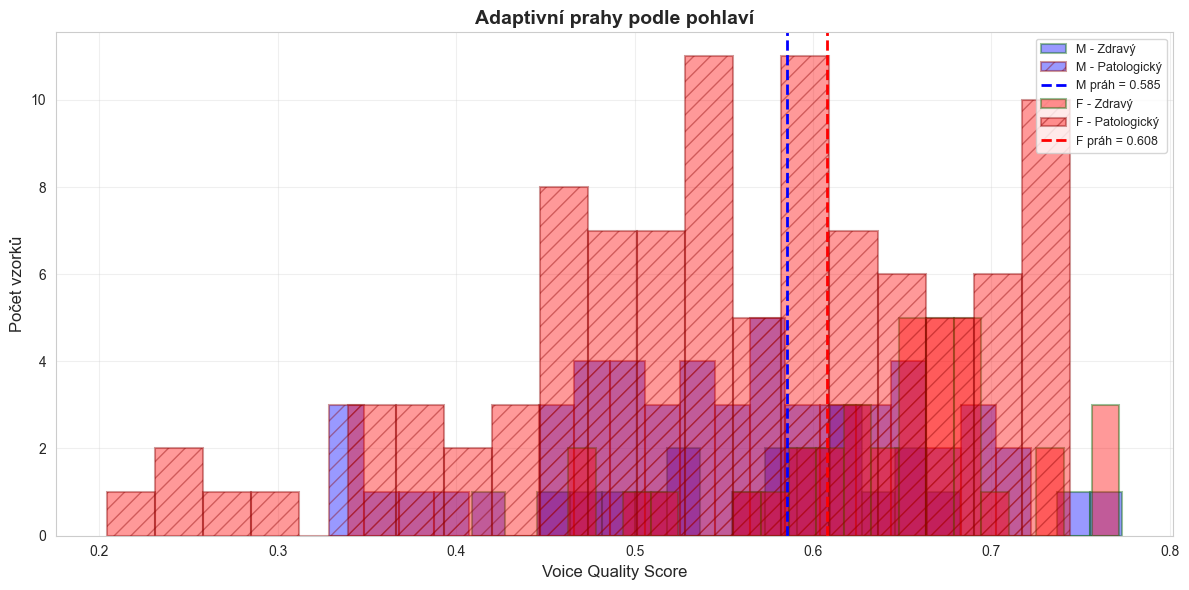

In [10]:
# === STRATEGIE 2: ADAPTIVNÍ PRAHY PODLE POHLAVÍ ===

print("STRATEGIE 2: Adaptivní prahy M/F")
print("="*70)

# Filtrujeme jen záznamy s platným pohlavím
df_gendered = df[df['sex'].isin(['M', 'F'])].copy()

print(f"\nPočet záznamů s určeným pohlavím: {len(df_gendered)}/{len(df)}")
print(f"   Muži: {(df_gendered['sex']=='M').sum()}")
print(f"   Ženy: {(df_gendered['sex']=='F').sum()}")

# Separátní optimalizace prahů pro M a F
results_gendered = {}

for gender in ['M', 'F']:
    df_gender = df_gendered[df_gendered['sex'] == gender]
    
    print(f"\n{'─'*50}")
    print(f"Optimalizace pro pohlaví: {gender}")
    print(f"   Počet vzorků: {len(df_gender)} ({df_gender['is_healthy'].sum()} zdravých)")
    
    best_bal = 0
    best_t = 0
    best_m = {}
    
    for threshold in np.linspace(df_gender['score_weighted'].min(), 
                                df_gender['score_weighted'].max(), 150):
        pred = df_gender['score_weighted'] > threshold
        y_true = df_gender['is_healthy'].values
        
        tn = np.sum((~y_true) & (~pred))
        fp = np.sum((~y_true) & pred)
        fn = np.sum(y_true & (~pred))
        tp = np.sum(y_true & pred)
        
        if (tp + fn) == 0 or (tn + fp) == 0:
            continue
        
        acc = (tn + tp) / len(df_gender)
        sens = tp / (tp + fn)
        spec = tn / (tn + fp)
        bal = (sens + spec) / 2
        
        if bal > best_bal:
            best_bal = bal
            best_t = threshold
            best_m = {'acc': acc * 100, 'sens': sens * 100, 'spec': spec * 100,
                     'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}
    
    results_gendered[gender] = {
        'threshold': best_t,
        'bal_acc': best_bal * 100,
        'metrics': best_m
    }
    
    print(f"   ✓ Optimální práh: {best_t:.4f}")
    print(f"   ✓ Balanced Acc: {best_bal * 100:.2f}%")

# Aplikace genderově specifických prahů
df_gendered['prediction'] = False

for gender in ['M', 'F']:
    mask = df_gendered['sex'] == gender
    threshold = results_gendered[gender]['threshold']
    df_gendered.loc[mask, 'prediction'] = df_gendered.loc[mask, 'score_weighted'] > threshold

# Celkové metriky
y_true = df_gendered['is_healthy'].values
y_pred = df_gendered['prediction'].values

tn = np.sum((~y_true) & (~y_pred))
fp = np.sum((~y_true) & y_pred)
fn = np.sum(y_true & (~y_pred))
tp = np.sum(y_true & y_pred)

acc = (tn + tp) / len(df_gendered)
sens = tp / (tp + fn)
spec = tn / (tn + fp)
bal = (sens + spec) / 2

print(f"\n{'='*70}")
print("CELKOVÉ VÝSLEDKY S ADAPTIVNÍMI PRAHY:")
print(f"{'='*70}")
print(f"   Celková přesnost: {acc * 100:.2f}%")
print(f"   Balanced Accuracy: {bal * 100:.2f}%")
print(f"   Sensitivita: {sens * 100:.2f}%")
print(f"   Specificita: {spec * 100:.2f}%")

improvement = bal * 100 - baseline_bal
print(f"\nZlepšení oproti baseline: {improvement:+.2f}% bodů")

# Vizualizace rozdílu prahů
fig, ax = plt.subplots(figsize=(12, 6))

for gender, color in [('M', 'blue'), ('F', 'red')]:
    df_g = df_gendered[df_gendered['sex'] == gender]
    
    # Zdraví
    df_healthy = df_g[df_g['is_healthy']]
    df_patho = df_g[~df_g['is_healthy']]
    
    ax.hist(df_healthy['score_weighted'], bins=20, alpha=0.4, 
           label=f'{gender} - Zdravý', color=color, edgecolor='darkgreen', linewidth=1.5)
    ax.hist(df_patho['score_weighted'], bins=20, alpha=0.4,
           label=f'{gender} - Patologický', color=color, edgecolor='darkred', linewidth=1.5, hatch='//')
    
    # Práh
    threshold = results_gendered[gender]['threshold']
    ax.axvline(threshold, color=color, linestyle='--', linewidth=2,
              label=f'{gender} práh = {threshold:.3f}')

ax.set_xlabel('Voice Quality Score', fontsize=12)
ax.set_ylabel('Počet vzorků', fontsize=12)
ax.set_title('Adaptivní prahy podle pohlaví', fontsize=14, fontweight='bold')
ax.legend(loc='upper right', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

adaptive_bal = bal * 100